In [1]:
# PyTorch port of the model used to train the DERM12345 dataset.
# Author: Suraj Neupane
# Datset  tested on: DERM12345 (40 classes)

import torch
from torch import nn

from torch.utils.data import Dataset # Base dataset class
from torch.utils.data import DataLoader # For batching and shuffling data

from torchvision import datasets # For built-in datasets
from torchvision import transforms # For transforming data from one format to another
import torchvision.models as models # For ResNet50 pre-trained model

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# Load the dataset
# The original images are of random sizes, which we will transform to 224x224
image_transforms = transforms.Compose(
    [transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
)
train_dataset = datasets.ImageFolder(root='./datasets/DERM12345/derm12345_train/', transform=image_transforms)
test_dataset = datasets.ImageFolder(root='./datasets/DERM12345/derm12345_test/', transform=image_transforms)

In [4]:
len(train_dataset), len(test_dataset)

(9860, 2485)

In [5]:
# All the classes of the train dataset
data_classes = train_dataset.classes
data_classes

['acb',
 'acd',
 'ajb',
 'ajd',
 'ak',
 'alm',
 'angk',
 'anm',
 'bcc',
 'bd',
 'bdb',
 'cb',
 'ccb',
 'ccd',
 'cd',
 'ch',
 'cjb',
 'db',
 'df',
 'dfsp',
 'ha',
 'isl',
 'jb',
 'jd',
 'ks',
 'la',
 'lk',
 'lm',
 'lmm',
 'ls',
 'mcb',
 'mel',
 'mpd',
 'pg',
 'rd',
 'sa',
 'scc',
 'sk',
 'sl',
 'srjd']

In [6]:
# Get the first image from the training dataset
image_tensor, label = train_dataset[0]
image_tensor.shape, label

(torch.Size([3, 224, 224]), 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.0539435].


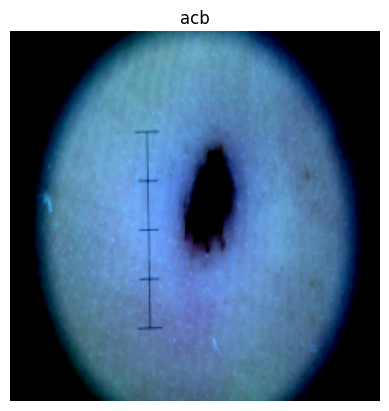

In [7]:
# Visualize the image
import matplotlib.pyplot as plt
%matplotlib inline

plt.axis(False)
plt.title(data_classes[label])
plt.imshow(image_tensor.permute(1, 2, 0)) # Convert from pytorch's (C, H, W) format to (H, W, C) as matplotlib expects.

In [8]:
# Convert the entire dataset into batches of data
batch_size = 64

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [9]:
# Get the batches of data from the dataloader
train_iterator = iter(train_dataloader)
test_iterator = iter(test_dataloader)

first_batch_images, first_batch_labels = next(train_iterator)
first_batch_images.shape, first_batch_labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [10]:
len(train_dataloader) # Total number of batches of data

155

In [11]:
# Let's see the first 5 images of our first batch of images to check if shuffling was done or not 
def show_torch_image(image):
    plt.imshow(image.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7069099..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.107843..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3512855..1.8858544].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.3785625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.897759..1.733682].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3130406..1.7282913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7906162..

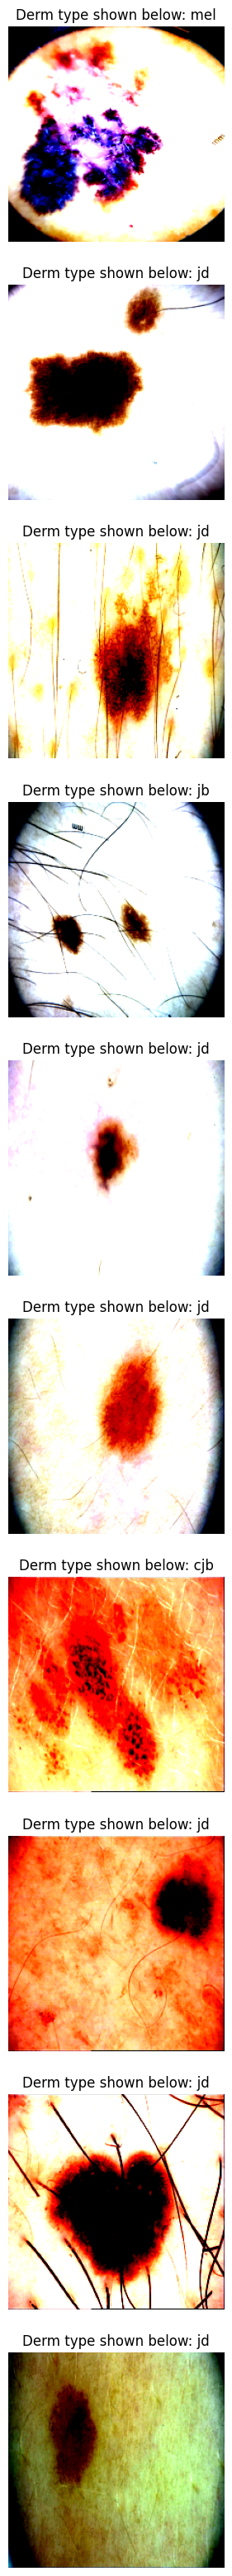

In [12]:
# Create the canvas
fig = plt.figure(figsize=(20, 40)) # W -> 20 inches, H -> 20 inches 
img_count = 10
for i in range(1, img_count+1):
    plt.subplot(img_count, 1, i)
    plt.axis(False)
    plt.title(f'Derm type shown below: {data_classes[first_batch_labels[i]]}')
    show_torch_image(first_batch_images[i])

In [13]:
# Create the model.
class DERM12345_Classifier(nn.Module):
    def __init__(self, base_model, classifier_in_features, num_classes):
        super().__init__()
        
        # Freeze the base model (Cannot update the weights of the base model during optimization)
        for param in base_model.parameters():
            param.requires_grad = False
        
        self.base_model = base_model

        # Custom classifier layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(classifier_in_features, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)
        self.fc4 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        with torch.no_grad():  # Ensure base model remains frozen
            x = self.base_model(x)
        
        x = self.global_avg_pool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        
        return x

In [14]:
# Load the pre-trained ResNet18 model
model = models.resnet50(pretrained=True).to(device)

C:\Users\nsura\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nsura\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
# Get the fully connected layer's in_features 
classifier_layer_features = model.fc.in_features

In [16]:
# Remove the final fully connected layer (classification layer)
model = torch.nn.Sequential(*list(model.children())[:-1]).to(device)

# Instantiate our custom model
custom_model = DERM12345_Classifier(model, classifier_layer_features, 40).to(device)

In [17]:
# Check if the model is working or not by passing a single image tensor through it
sample_image = first_batch_images[5] # Fifth image from the first batch
sample_image = sample_image.unsqueeze(dim=0)

label = first_batch_labels[5] # Its corresponding label

sample_image.shape, label

(torch.Size([1, 3, 224, 224]), tensor(23))

In [18]:
# Passing a single image tensor through the model
logits = custom_model(sample_image.to(device))
logits

tensor([[ 0.1195, -0.0815,  0.0992,  0.0536, -0.0666, -0.0144,  0.1107,  0.1533,
          0.1077, -0.0410, -0.0014,  0.0608, -0.0503,  0.0019,  0.1459, -0.0398,
          0.0371, -0.0393, -0.1032,  0.1172,  0.0204, -0.0618, -0.0693, -0.0744,
          0.0284, -0.0307, -0.0302,  0.0513, -0.0145,  0.0932, -0.0538, -0.0245,
         -0.1047, -0.0199,  0.0243,  0.0143, -0.0192, -0.0063, -0.0229,  0.1227]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [19]:
# The model's prediction before training it (garbage)
predicted_class = logits.argmax(dim=1)
print(f'Model prediction before training: {data_classes[predicted_class.item()]}')

Model prediction before training: anm


In [20]:
# Create the loss function and the optimizer
loss_function = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.SGD(custom_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

In [21]:
# Accuracy function
def calculate_accuracy(batch_logits, batch_labels):
    pred_classes = batch_logits.argmax(dim=1)
    num_correct_classes = (pred_classes == batch_labels).sum()

    accuracy = (num_correct_classes / len(batch_labels)) * 100.0
    return accuracy

In [22]:
# Training and Testing loops
def train_step(batches_X, labels_y):
    '''
    Sends a batch of training data through the model, calculates the loss, performs backpropagation and updates the model's parameters.
    RETURN VALUE(s): The loss of the current training setp.
    '''
    # Forward pass
    logits = custom_model(batches_X)
    # Calculate the loss
    loss = loss_function(logits, labels_y)

    # Clear the gradients stored in the model's parameters from previous backpropagation
    optimizer.zero_grad()

    # Backpropagation (Calculate the gradients)
    loss.backward()

    # Update the model's parameters
    optimizer.step()

    return loss.item()

In [23]:
def test_step(test_dataloader):
    '''
    Sends the entire testing dataset through the model and calculates model's performance on the testing set.
    RETURN VALUE(s): A python dict containing i. The loss of the current testing step and ii. The accuracy of the model on the testing set.
    '''
    average_loss = 0
    average_accuracy = 0
    for [X, y] in test_dataloader:
        logits = custom_model(X.to(device))
        
        loss = loss_function(logits, y.to(device))
        average_loss += loss.item()
        average_accuracy += calculate_accuracy(logits, y.to(device))

    average_loss /= len(test_dataloader)
    average_accuracy /= len(test_dataloader)
    
    return {'loss': average_loss, 'accuracy': average_accuracy}

In [ ]:
# Train the model
epochs = 50

for i in range(0, epochs):
    batch = 1
    print(f'---------- Epoch: {i} ----------')
    for [X, y] in train_dataloader:
        # Train the model
        train_loss = train_step(X.to(device), y.to(device))

        # Only start testing the model once you reach epoch 90
        if i > 20:
            # Test the model
            stats = test_step(test_dataloader)
            test_loss = stats['loss']
            test_accuracy = stats['accuracy']
            
        if batch%20 == 0 and i > 20:
            print(f'Batches seen: {batch}/{len(train_dataloader)}. Training Loss: {train_loss}. Testing loss: {test_loss}. Test Accuracy: {test_accuracy}')
        elif batch%20 == 0:
            print(f'Batches seen: {batch}/{len(train_dataloader)}. Training Loss: {train_loss}.')
            
        batch += 1

---------- Epoch: 0 ----------
Batches seen: 20/155. Training Loss: 3.66050386428833.
Batches seen: 40/155. Training Loss: 3.5517449378967285.
Batches seen: 60/155. Training Loss: 3.313371181488037.
Batches seen: 80/155. Training Loss: 2.8425204753875732.
Batches seen: 100/155. Training Loss: 2.7522783279418945.
Batches seen: 120/155. Training Loss: 2.47884464263916.
Batches seen: 140/155. Training Loss: 2.6198766231536865.
---------- Epoch: 1 ----------
